<b><font color="red">Importa bibliotecas

In [2]:
import os
import urllib.request
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

<b><font color="red"><h2> 1 - Classificação Binária

<b><font color="red"> Configurando o ambiente

In [ ]:
os.mkdir('./dados')
os.mkdir('./img')

In [4]:
pst_dados = os.path.abspath(os.path.relpath('./dados'))
caminho_arquivo = os.path.join(pst_dados, 'two_moons.csv')
pst_imagens = os.path.abspath(os.path.relpath('./imagens'))

url_download_dados = 'http://www.dca.fee.unicamp.br/~lboccato/two_moons.csv'
urllib.request.urlretrieve(url_download_dados, caminho_arquivo)

('/home/jimi/Unicamp/ia006/list2/algoritimos/dados/two_moons.csv',
 <http.client.HTTPMessage at 0x7fdfe476b0f0>)

In [5]:
%%bash 
head './dados/two_moons.csv'

,x_1,x_2,y
0,2.0644296514467197,0.546069086070731,1.0
1,1.762473261484448,-0.06268920285178106,1.0
2,-0.24548972654900278,1.068868024796405,0.0
3,-0.17463045222800389,0.18388168037297553,1.0
4,0.4521100769674068,-0.40651213749666293,1.0
5,1.9396117132053508,0.43090598314745787,1.0
6,0.898613370647941,0.8226576504874641,0.0
7,0.052218958530233006,1.3636857785600163,0.0
8,-0.6284662881051902,1.1413048711192604,0.0


<b><font color="red"> Importa dados

In [6]:
dados = np.loadtxt(caminho_arquivo, skiprows=1, usecols=(1,2,3), delimiter=',')

In [7]:
dados

array([[ 2.06442965,  0.54606909,  1.        ],
       [ 1.76247326, -0.0626892 ,  1.        ],
       [-0.24548973,  1.06886802,  0.        ],
       ...,
       [ 0.35132285, -0.53361311,  1.        ],
       [ 0.15631506,  0.08097761,  1.        ],
       [ 0.51401549, -0.50367604,  1.        ]])

In [8]:
x_1_2 = dados[:,0:2]
y = dados[:,2].astype(int)
y = y.reshape((y.shape[0], 1))
dados.shape, x_1_2.shape, x_1_2.shape

((1000, 3), (1000, 2), (1000, 2))

In [9]:
dados

array([[ 2.06442965,  0.54606909,  1.        ],
       [ 1.76247326, -0.0626892 ,  1.        ],
       [-0.24548973,  1.06886802,  0.        ],
       ...,
       [ 0.35132285, -0.53361311,  1.        ],
       [ 0.15631506,  0.08097761,  1.        ],
       [ 0.51401549, -0.50367604,  1.        ]])

In [10]:
x_1_2

array([[ 2.06442965,  0.54606909],
       [ 1.76247326, -0.0626892 ],
       [-0.24548973,  1.06886802],
       ...,
       [ 0.35132285, -0.53361311],
       [ 0.15631506,  0.08097761],
       [ 0.51401549, -0.50367604]])

In [11]:
y

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
    

In [12]:
Phi = np.column_stack((np.ones(x_1_2.shape[0]), x_1_2))
Phi.shape

(1000, 3)

In [13]:
lista1 = [i for i, e in enumerate(y) if e]
lista0 = [i for i, e in enumerate(y) if not e]

In [13]:
lista0

[2,
 6,
 7,
 8,
 10,
 13,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 27,
 29,
 34,
 37,
 39,
 40,
 44,
 47,
 48,
 50,
 51,
 52,
 53,
 56,
 57,
 59,
 62,
 63,
 64,
 65,
 66,
 68,
 71,
 73,
 75,
 76,
 80,
 81,
 82,
 86,
 88,
 90,
 91,
 93,
 95,
 97,
 98,
 102,
 104,
 109,
 110,
 112,
 114,
 115,
 117,
 118,
 122,
 124,
 126,
 127,
 130,
 136,
 137,
 140,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 156,
 157,
 159,
 165,
 166,
 168,
 169,
 172,
 174,
 176,
 179,
 182,
 183,
 187,
 189,
 192,
 193,
 197,
 199,
 202,
 210,
 212,
 216,
 217,
 218,
 223,
 224,
 225,
 228,
 229,
 231,
 234,
 235,
 237,
 239,
 241,
 242,
 243,
 245,
 246,
 247,
 248,
 250,
 252,
 254,
 257,
 259,
 262,
 263,
 267,
 268,
 269,
 272,
 273,
 278,
 279,
 281,
 282,
 285,
 288,
 289,
 291,
 295,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 308,
 313,
 315,
 316,
 317,
 318,
 319,
 320,
 323,
 324,
 325,
 326,
 328,
 332,
 334,
 335,
 336,
 338,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,


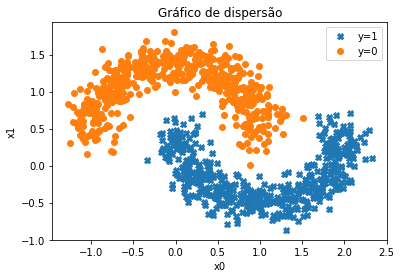

In [14]:
plt.plot(x_1_2[lista1,0], x_1_2[lista1,1], 'X')
plt.plot(x_1_2[lista0,0], x_1_2[lista0,1], 'o')
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Gráfico de dispersão")
plt.legend(['y=1', 'y=0'])
plt.savefig(os.path.join(pst_imagens, 'dados.png'), bbox_inches='tight')
plt.show()

<b><font color="red">Os modelos lineares não são capazes de separar o modelo

<b><font color="red"> Discriminante linear de Fischer

In [15]:
y_chapeu = lambda w, X: np.dot(X, w)

In [16]:
Sw = np.zeros((2,2))
mi1 = np.mean(x_1_2[lista1], 0)
mi0 = np.mean(x_1_2[lista0], 0)

for i in lista0:
    Sw += np.dot((x_1_2[i].reshape((2,1)) - mi0.reshape((1,2))),((x_1_2[i].reshape((2,1)) - mi0.reshape((1,2)))).T)
for i in lista1:
    Sw += np.dot((x_1_2[i].reshape((2,1)) - mi1.reshape((1,2))),((x_1_2[i].reshape((2,1)) - mi1.reshape((1,2)))).T)
Sw

array([[ 2.23939149e+03, -5.36498142e-02],
       [-5.36498142e-02,  1.43394973e+03]])

In [17]:
Sb = np.dot((mi1 - mi0),(mi1 - mi0).T)
Sb

2.4003468221575144

In [23]:
J = lambda w: np.dot(np.dot(w.T, Sb), w)/np.dot(np.dot(w.T, Sw), w)
J

<function __main__.<lambda>>

In [24]:
w = np.dot(np.linalg.inv(Sw),(mi1 - mi0))
w = w/np.linalg.norm(w)
w

array([ 0.48042956, -0.87703332])

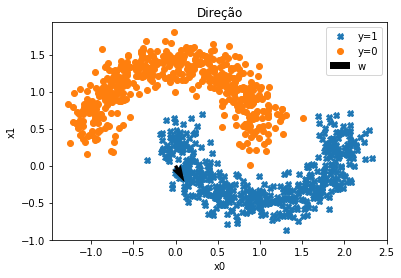

In [25]:
plt.plot(x_1_2[lista1, 0], x_1_2[lista1,1], 'X', zorder=1)
plt.plot(x_1_2[lista0, 0], x_1_2[lista0,1], 'o', zorder=2)


origin = [0], [0] # origin point
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Direção")
plt.quiver(*origin, w[0], w[1], width=0.010, color='black', zorder=3)

plt.legend(['y=1', 'y=0', 'w'])
plt.savefig(os.path.join(pst_imagens, 'dir_proj.png'), bbox_inches='tight')
plt.show()

<b><font color="red"><h2> Projeção em w

In [27]:
x_1_2

array([[ 2.06442965,  0.54606909],
       [ 1.76247326, -0.0626892 ],
       [-0.24548973,  1.06886802],
       ...,
       [ 0.35132285, -0.53361311],
       [ 0.15631506,  0.08097761],
       [ 0.51401549, -0.50367604]])

In [28]:
mi = np.array([np.average(x_1_2[:,0]), np.average(x_1_2[:,1])])
delta = np.array([(np.max(x_1_2[:,0]) - np.min(x_1_2[:,0])), (np.max(x_1_2[:,1]) - np.min(x_1_2[:,1]))])

x_1_2 = (x_1_2 - np.ones([x_1_2.shape[0],1])*mi)*(np.ones([x_1_2.shape[0],1])*(1/delta))

In [29]:
lda = lambda x_1_2, w: np.dot(x_1_2, w)#ERRO POR AQUI

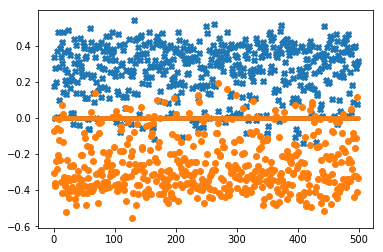

In [30]:
out = lda(x_1_2, w)
plt.stem(out[lista1], basefmt='.', linefmt='C0.', markerfmt='C0X')
plt.stem(out[lista0], basefmt='.', linefmt='C1.', markerfmt='C1o')
plt.savefig(os.path.join(pst_imagens, 'stem.png'), bbox_inches='tight')
plt.show()

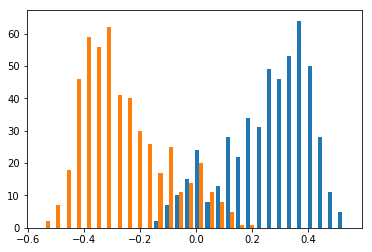

In [31]:
plt.hist([out[lista1], out[lista0]], bins=30, color=['C0', 'C1'])
plt.savefig(os.path.join(pst_imagens, 'histograma.png'), bbox_inches='tight')
plt.show()

<b><font color="red">Com um tratamento linear, obtemos um resultado pouco satisfatório, com muitos dados conflitantes entre os valores -0.2 e 0.2

<b><font color="red"> ROC

In [32]:
def decision(x_1_2, w, thres, model):
    out = model(x_1_2, w)
    return np.array([1 if e > thres else 0 for e in out])

In [33]:
def confusion(out, y):
    tp = fp = tn = fn = 0
    for i, e in enumerate(out):
        if e:
            if y[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y[i]:
                fn += 1
            else:
                tn += 1
    return tp, fp, fn, tn

In [34]:
def roc_curve(x_1_2, y, w, thres_v, model):
    roc = []
    f1_v = []
    for t in thres_v:
        out = decision(x_1_2, w, t, model)
        tp, fp, fn, tn = confusion(out, y)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*tp/(2*tp + fn + fp)
        f1_v.append([t, f1])
        roc.append([fpr, tpr])
    return np.array(roc), np.array(f1_v)

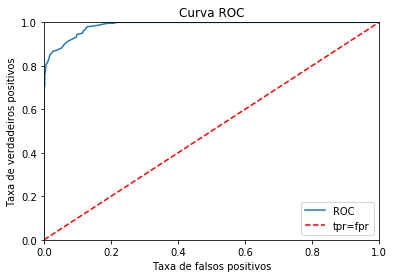

In [35]:
thres_v = [0.01*e for e in range(-200, 201)]
roc, f1 = roc_curve(x_1_2, y, w, thres_v, lda)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Curva ROC")
plt.legend(["ROC", "tpr=fpr"])

plt.ylabel('Taxa de verdadeiros positivos')
plt.xlabel('Taxa de falsos positivos')

plt.savefig(os.path.join(pst_imagens, 'roc.png'), bbox_inches='tight')
plt.show()

#### F1 

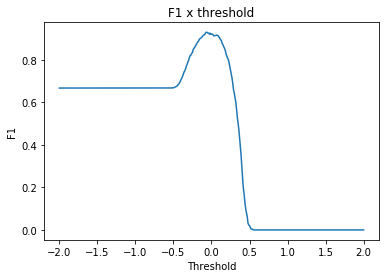

Threshold com maior pontuação f1 = -0.07, (0.9289)


In [37]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 x threshold")
plt.ylabel('F1')
plt.xlabel('Threshold')
plt.savefig(os.path.join(pst_imagens, 'f1.png'), bbox_inches='tight')
plt.show()
print("Threshold com maior pontuação f1 = {}, ({:.4f})".format(f1[np.argmax(f1[:,1]), 0], f1[np.argmax(f1[:,1]), 1]))

<b><font color="red">Aqui, vemos que, para valores próximos a 0 o modelo tem a melhor média de f1, o valor ótimo, no teste acima, foi: f1 = -0.07, (0.9289)

<b><font color="red"><h2> Regressão Logística

In [38]:
g = lambda z: 1/(1 + np.exp(-z))

In [39]:
lr = lambda Phi, w: g(np.dot(Phi, w))

In [40]:
mmq = lambda Phi, y: np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), y)

In [41]:
w = mmq(Phi, y)

In [42]:
def J(y_chapeu, y):
    J = 0
    for e, f in zip(y, y_chapeu):
        J += e*np.log10(f) + (1-e)*np.log10(1-f)
    return (-J/y.shape[0])[0]

In [43]:
def gradient_descent_step(Phi, y_chapeu, y, w, alpha):
    grad = -np.dot((y - y_chapeu).T, Phi)/y_chapeu.shape[0]
    grad = np.sum(grad, 0)/y_chapeu.shape[0]
    grad = grad.reshape((grad.shape[0], 1))
    return w - alpha*grad

In [58]:
def gradient_descent(Phi, y, w, alpha, epochs, early_stop_param, v=0):
    epoch = count = 0
    min_error = 999
    while epoch < epochs and count < early_stop_param:
        y_chapeu = lr(Phi, w)
        error = J(y_chapeu, y)
        w = gradient_descent_step(Phi, y_chapeu, y, w, alpha)
        if error < min_error:
            min_error = error
            count = 0
        else:
            count += 1
        if v:
            print('Calculando o gradiente descendente, aguarde...')
        epoch += 1
    
    return w

In [59]:
w = 0.1*np.random.random([3])
w = w.reshape((w.shape[0], 1))

In [60]:
w = gradient_descent(Phi, y, w, 5, 5000, 10, 1)

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o gradiente descendente, aguarde...
Calculando o 

In [61]:
w

array([[ 0.37266441],
       [ 1.1835959 ],
       [-2.54346155]])

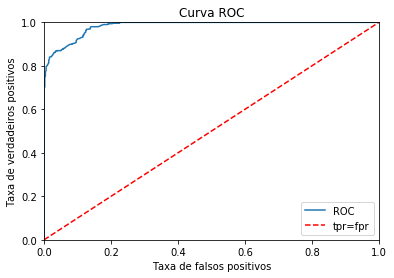

In [62]:
thres_v = [0.001*e for e in range(0,1001, 5)]
roc, f1 = roc_curve(Phi, y, w, thres_v, lr)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Curva ROC")
plt.legend(["ROC", "tpr=fpr"])
plt.ylabel('Taxa de verdadeiros positivos')
plt.xlabel('Taxa de falsos positivos')
plt.savefig(os.path.join(pst_imagens, 'roc.png'), bbox_inches='tight')
plt.show()

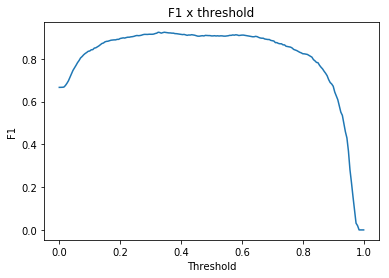

Maior pontuação de F1: 0.3450, (0.9245)


In [64]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 x threshold")
plt.ylabel('F1')
plt.xlabel('Threshold')
plt.savefig(os.path.join(pst_imagens, 'f1.png'), bbox_inches='tight')
plt.show()
print("Maior pontuação de F1: {:.4f}, ({:.4f})".format(f1[np.argmax(f1[:,1]), 0], f1[np.argmax(f1[:,1]), 1]))

<b>
Percebe-se que o modelo de regressão logística possui uma grande quantidade de valores para treshold, isso levando em consideração os valores parecidos em F1.

Conclui-se que ambos os modelos obtiveram valores próximos da f1!

Considera-se um método bom para o problema tratado no exercício.



<b><font color="red"><h1>2 - Classificação multi-classe

<b><font color="red"> Download dados

In [109]:
url_download_dados = 'http://www.dca.fee.unicamp.br/~lboccato/dataset_vehicle.csv'
caminho_arquivo = os.path.join(pst_dados, 'dataset_vehicle.csv') 
 
urllib.request.urlretrieve(url_download_dados, caminho_arquivo)

('/home/jimi/Unicamp/ia006/list2/algoritimos/dados/dataset_vehicle.csv',
 <http.client.HTTPMessage at 0x7fdff0fdf4e0>)

In [110]:
%%bash
head "./dados/dataset_vehicle.csv"

"COMPACTNESS","CIRCULARITY","DISTANCE_CIRCULARITY","RADIUS_RATIO","PR.AXIS_ASPECT_RATIO","MAX.LENGTH_ASPECT_RATIO","SCATTER_RATIO","ELONGATEDNESS","PR.AXIS_RECTANGULARITY","MAX.LENGTH_RECTANGULARITY","SCALED_VARIANCE_MAJOR","SCALED_VARIANCE_MINOR","SCALED_RADIUS_OF_GYRATION","SKEWNESS_ABOUT_MAJOR","SKEWNESS_ABOUT_MINOR","KURTOSIS_ABOUT_MAJOR","KURTOSIS_ABOUT_MINOR","HOLLOWS_RATIO","Class"
95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van


<b><font color="red">
    Importa dados

In [111]:
X = np.loadtxt(caminho_arquivo, skiprows=1, usecols=range(18), delimiter=',')
X.shape

(846, 18)

In [112]:
y = []
with open(caminho_arquivo) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        y.append(row['Class'])   
len(y)

846

In [113]:
classes = list(set(y))
classes

['van', 'opel', 'saab', 'bus']

In [114]:
Y = np.zeros((len(y), len(classes)))
for i, e in enumerate(y):
    if e == classes[0]:
        Y[i,0] = 1
    elif e == classes[1]:
        Y[i,1] = 1
    elif e == classes[2]:
        Y[i,2] = 1
    else:
        Y[i,3] = 1
Y.shape

(846, 4)

In [115]:
holdout_n = int(0.3*len(y))

In [116]:
mi = np.array([np.average(X[:,i]) for i in range(X.shape[1])])
delta = np.array([(np.max(X[:,i]) - np.min(X[:,i])) for i in range(X.shape[1])])

X = (X - np.ones([X.shape[0],1])*mi)*(np.ones([X.shape[0],1])*(1/delta))

In [117]:
X_test = X[:holdout_n, :]
X_train = X[holdout_n:,:]
Y_test = Y[:holdout_n, :]
Y_train = Y[holdout_n:,:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((593, 18), (253, 18), (593, 4), (253, 4))

In [118]:
Phi_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
Phi_test = np.column_stack((np.ones(X_test.shape[0]), X_test))

<b><font color="red"> Regressão Logística

In [128]:
Q = len(classes)
W = 0.01*np.random.random(((Q*(Q-1))//2, Phi_test.shape[1]))
W.shape

(6, 19)

In [129]:
k = 0
mask = [[]]*W.shape[0]
aux = []
for i in range(Q-1):
    for j in range(i+1, Q):
        mask[k] = [l for l, (e, f) in enumerate(zip(Y_train[:,i],Y_train[:,j])) if (e or f)]
        k += 1
        aux.append((i, j))

In [130]:
for i, m in enumerate(mask):
    w = W[i].reshape((W.shape[1], 1))
    y = Y_train[m,aux[i][0]].reshape((Y_train[m].shape[0], 1))
    X = Phi_train[m,:]
    grad = gradient_descent(X, y, w, 1000, 5000, 5)[:,0]
    W[i] = grad[:]

In [131]:
def one_vs_one(Phi, W):
    votes = np.zeros((Phi.shape[0], 4))
    ans = []

    for i, a in enumerate(aux):
        w = W[i].reshape((W.shape[1], 1))
        X = Phi
        y = lr(X, w)
        for j, e in enumerate(y):
            votes[j, a[0]] += e
            votes[j, a[1]] += 1-e
    for e in votes:
        print(e)
        ans.append(np.argmax(e))
    return ans

In [132]:
y_chapeu = one_vs_one(Phi_test, W)

[2.8583663  1.00690268 1.79517905 0.33955197]
[2.87469946 1.13443819 1.9764863  0.01437605]
[2.99612732e-04 2.10066603e+00 2.89291255e+00 1.00612180e+00]
[2.98004966 1.58187054 1.2482999  0.1897799 ]
[2.98897377 0.42762126 0.57238052 2.01102445]
[1.58468816e-10 2.03652069e+00 1.05365491e+00 2.90982440e+00]
[0.36229049 1.1409904  1.73299486 2.76372425]
[2.97344927 0.75361062 1.27284773 1.00009238]
[2.9420571  1.43336536 0.89939535 0.7251822 ]
[2.62686571e-03 2.76836638e+00 2.21437865e+00 1.01462811e+00]
[2.57153934 1.66114544 1.59976106 0.16755416]
[1.22781189 2.55045061 2.17856644 0.04317106]
[0.17830402 1.43530561 1.54859796 2.83779241]
[2.73732304 1.30287931 1.93489305 0.0249046 ]
[2.44519636e-03 1.85788490e+00 1.14173930e+00 2.99793060e+00]
[1.63813462e-04 2.34698565e+00 2.29890645e+00 1.35394408e+00]
[2.9752068  1.17583363 1.35289475 0.49606483]
[8.62114634e-04 1.85569442e+00 1.14652979e+00 2.99691368e+00]
[0.00612964 2.33908177 2.48409155 1.17069704]
[5.92256819e-04 2.65707322e+00

In [142]:
y_chapeu = np.zeros((len(y), len(classes)))
for i, e in enumerate(y):
    if e == classes[0]:
        y_chapeu[i,0] = 1
    elif e == classes[1]:
        y_chapeu[i,1] = 1
    elif e == classes[2]:
        y_chapeu[i,2] = 1
    else:
        y_chapeu[i,3] = 1

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [141]:
y_test = np.argmax(Y_test, 1)
np.sum((y_test == np.array(y_chapeu)))/y_test.shape[0]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


0.0

In [135]:
def confusion(y_chapeu, y, n_classes):
    ans = np.zeros((n_classes, n_classes))
    for i, (e, f) in enumerate(zip(y, y_chapeu)):
        ans[int(e)][int(f)] += 1
    return ans

In [138]:
print(classes)
cm = confusion(y_chapeu, y_test, len(classes))

['van', 'opel', 'saab', 'bus']


TypeError: only size-1 arrays can be converted to Python scalars

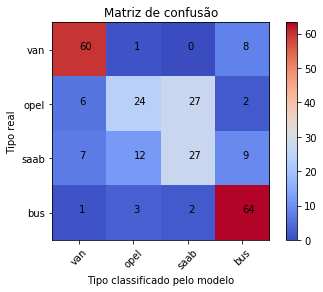

Precisão ~: 0.6917


In [148]:
N = len(y_test)/4
cax = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0, vmax=N)
classNames = classes
plt.title('Matriz de confusão')
plt.ylabel('Tipo real')
plt.xlabel('Tipo classificado pelo modelo')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
for i, e in enumerate(cm):
    for j, f in enumerate(e):
        plt.text(j,i, str(int(cm[i][j])))
plt.colorbar(cax)
plt.show()
print("Precisão ~: {:.4f}".format(np.sum(np.diag(cm))/np.sum(cm)))

<b>Como um onibus e uma van tem a aparência bem diferentes, o modelo conseguiu classificar melhor essas classes, uma vez que, os veículos 'opel' e 'saab' tem caracteristicas semelhantes, portanto, dados de entrada mais parecidos e, mais difíceis de classificar, quanto utilizado este modelo e meu limitado dominio da disciplina.

<b><font color="red">
    K-nearest Neighbours

In [100]:
d = lambda x, y, p: np.power(np.linalg.norm((x-y), p), 1./p)

In [101]:
def neighboors(x, X, k):
    dist = []
    for i, e in enumerate(X):
        dist.append(d(x, e, 2))
    dist = np.array(dist)
    ans = [[e, f] for e, f in zip(np.argsort(dist), np.sort(dist))]
    return ans[:k]

In [102]:
def knn(X_train, Y_train, x, k):
    X_prime = neighboors(x, X_train, k)
    mask = [n[0] for n in X_prime]
    classes = np.sum(Y_train[mask], 0)
    return np.argmax(classes)

In [103]:
def knn_predict(X_train, Y_train, X_test, k):
    y_test = np.empty(X_test.shape[0])
    for i, x in enumerate(X_test):
        y_test[i] =  knn(X_train, Y_train, x, k)
    return y_test

In [104]:
y_chapeu = knn_predict(X_train, Y_train, X_test, 10)

In [105]:
y_test = np.argmax(Y_test, 1)
np.sum((y_test == np.array(y_chapeu)))/y_test.shape[0]

0.691699604743083

In [106]:
avg_acc = np.sum(cm, 0)

NameError: name 'cm' is not defined

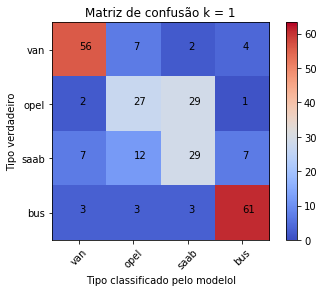

Precisão ~: 0.6838


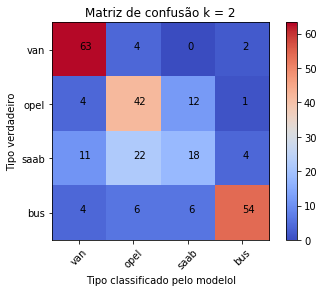

Precisão ~: 0.6996


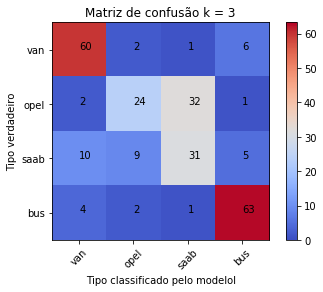

Precisão ~: 0.7036


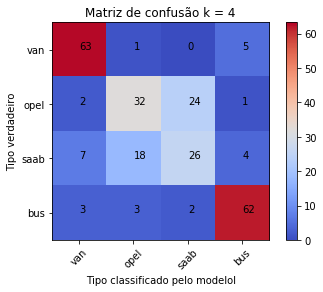

Precisão ~: 0.7233


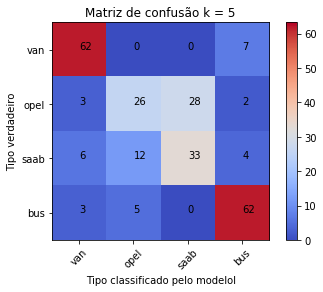

Precisão ~: 0.7233


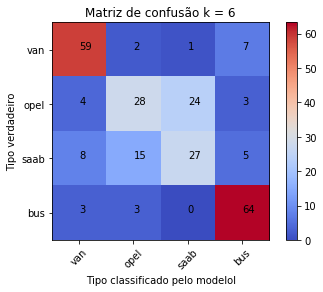

Precisão ~: 0.7036


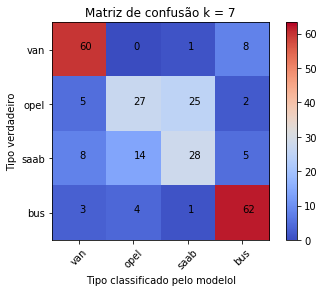

Precisão ~: 0.6996


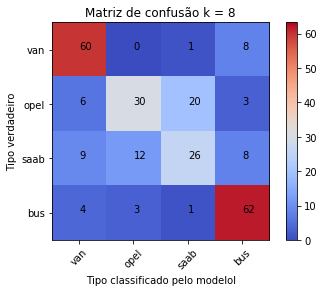

Precisão ~: 0.7036


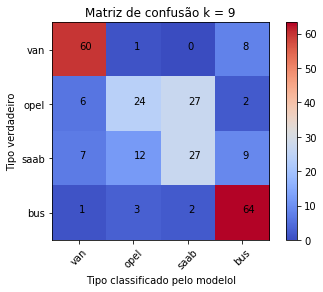

Precisão ~: 0.6917


In [146]:
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    y_chapeu = knn_predict(X_train, Y_train, X_test, k)
    cm = confusion(y_chapeu, y_test, len(classes))
    N = len(y_test)/4
    cax = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0, vmax=N)
    classNames = classes
    plt.title('Matriz de confusão k = '+str(k))
    plt.ylabel('Tipo verdadeiro')
    plt.xlabel('Tipo classificado pelo modelol')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i, e in enumerate(cm):
        for j, f in enumerate(e):
            plt.text(j,i, str(int(cm[i][j])))
    plt.colorbar(cax)
    plt.show()
    print("Precisão ~: {:.4f}".format(np.sum(np.diag(cm))/np.sum(cm)))

<b><font color="red"><h2> Conclusão </h></font></b>

Provavelmente eu cometi algum erro na codificação de alguns dos métodos, pois o K em 4 e 5 vizinhos mais próximos têm valores iguais.

Porém, acredito eu que, para este problema, um K com valor intermediário entre 1 e 10 seria o melhor modelo possível, de acordo com as minhas limitações nesta área de aprendizado de máquina.

Mesmo que algo me pareça errado, em ambos os códigos, knn e reg logistica, o knn obteve uma precisão um pouco melhor do que quando utilizada a reg. logistica.

Precisão ~: 0.6917 de para REGRESSÃO LOGÍSTICA contra | KNN Precisão ~: 0.7233 para os k's 4 e 5 testados acima.
